In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from scipy.sparse import hstack
from bs4 import BeautifulSoup
from sklearn import preprocessing
from wordcloud import WordCloud
import re
import pickle
from tqdm import tqdm
import os

# from plotly import plotly
# import plotly.offline as offline
# import plotly.graph_objs as go
# offline.init_notebook_mode()
# from collections import Counter

In [2]:
df = pd.read_csv("./drugsCom_raw/drugsComTrain_raw.tsv", index_col=False, sep='\t')
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [3]:
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [4]:
df.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   drugName     161297 non-null  object 
 1   condition    160398 non-null  object 
 2   review       161297 non-null  object 
 3   rating       161297 non-null  float64
 4   date         161297 non-null  object 
 5   usefulCount  161297 non-null  int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 7.4+ MB


In [6]:
df.isnull().sum()

drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [7]:
df.dropna(inplace=True)

In [8]:
df.condition

0         Left Ventricular Dysfunction
1                                 ADHD
2                        Birth Control
3                        Birth Control
4                    Opiate Dependence
                      ...             
161292              Alcohol Dependence
161293                 Nausea/Vomiting
161294            Rheumatoid Arthritis
161295             Underactive Thyroid
161296           Constipation, Chronic
Name: condition, Length: 160398, dtype: object

In [9]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [10]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "willnot", phrase)
    phrase = re.sub(r"can\'t", "cannot", phrase)
    phrase = re.sub(r"\"", "", phrase)
    phrase = re.sub(r"&#039", "\'", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", "not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentence in tqdm(text_data):
        sent = decontracted(sentence)
        sent = re.sub(r"http\S+", "", sentence)
        sent = BeautifulSoup(sentence, 'lxml').get_text()
        sent = decontracted(sentence)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [12]:
preprocessed_review = preprocess_text(df['review'].values)

100%|██████████| 160398/160398 [00:27<00:00, 5786.02it/s]


In [13]:
len(preprocessed_review)

160398

In [14]:
#tfidf essay
tfidf_essay = TfidfVectorizer(min_df=10, ngram_range=(1,2))
train_review = tfidf_essay.fit_transform(preprocessed_review)

In [15]:
tfidf_essay.get_feature_names()

['00',
 '00 00',
 '00 30',
 '00 co',
 '00 every',
 '00 insurance',
 '00 month',
 '00 morning',
 '00 not',
 '00 one',
 '00 per',
 '00 pm',
 '00 pocket',
 '00 started',
 '00 take',
 '00 took',
 '00 would',
 '000',
 '000 00',
 '000 000',
 '000 cd4',
 '000 mg',
 '000 steps',
 '000 undetectable',
 '000 viral',
 '000mg',
 '00am',
 '00pm',
 '01',
 '01 16',
 '02',
 '025',
 '025 cream',
 '03',
 '04',
 '05',
 '05 mg',
 '05mg',
 '06',
 '07',
 '08',
 '09',
 '09 first',
 '0mg',
 '10',
 '10 00',
 '10 000',
 '10 10',
 '10 11',
 '10 12',
 '10 13',
 '10 14',
 '10 15',
 '10 15lbs',
 '10 16',
 '10 17',
 '10 20',
 '10 2011',
 '10 2015',
 '10 2017',
 '10 20mg',
 '10 21',
 '10 23',
 '10 25',
 '10 27',
 '10 29',
 '10 30',
 '10 30am',
 '10 30pm',
 '10 325',
 '10 325mg',
 '10 40',
 '10 500',
 '10 650',
 '10 also',
 '10 amp',
 '10 bad',
 '10 body',
 '10 could',
 '10 coupon',
 '10 day',
 '10 days',
 '10 different',
 '10 dollars',
 '10 due',
 '10 effective',
 '10 effectiveness',
 '10 even',
 '10 every',
 '10 exce

In [16]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df.date.dt.year
df['month'] = df.date.dt.month
df['day_of_week'] = df.date.dt.day_of_week
df['day_of_year'] = df.date.dt.dayofyear

In [17]:
df.condition.values

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control', ...,
       'Rheumatoid Arthritis', 'Underactive Thyroid',
       'Constipation, Chronic'], dtype=object)

In [18]:
tfidf_drugName = TfidfVectorizer()
train_drugName = tfidf_drugName.fit_transform(df['drugName'].values)
train_drugName.shape

(160398, 3338)

In [19]:
tfidf_condition = TfidfVectorizer()
train_condition = tfidf_condition.fit_transform(df['condition'].values)
train_condition.shape

(160398, 1070)

In [20]:
minmax = preprocessing.MinMaxScaler()
df_usefulCount = df['usefulCount'].values
usefulCount = minmax.fit_transform([df_usefulCount])
usefulCount.reshape(-1,1).shape

(160398, 1)

In [21]:
scaler_rating = preprocessing.StandardScaler()
df_rating = df['rating'].values
rating = scaler_rating.fit_transform([df_rating])
rating.reshape(-1,1).shape

(160398, 1)

In [22]:
# train_vector = hstack((train_drugName, train_condition, train_review,
#                       usefulCount.reshape(-1,1), rating.reshape(-1,1), df[['year']], df[['month']],
#                       df[['day_of_week']], df[['day_of_year']])).tocsr()

In [23]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt

# X = train_vector
# distorsions = []
# for k in tqdm(range(2, 20)):
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(X)
#     distorsions.append(kmeans.inertia_)

# fig = plt.figure(figsize=(15, 5))
# plt.plot(range(2, 20), distorsions)
# plt.grid(True)
# plt.title('Elbow curve')

In [24]:
# km = KMeans(
#     n_clusters=5, init='random',
#     n_init=10, max_iter=300, 
#     tol=1e-04, random_state=0
# )
# y_km = km.fit_predict(train_vector)

In [25]:
# df['cluster'] = y_km
# df

In [26]:
ids = [tfidf_drugName, tfidf_condition, tfidf_essay]
numeric = ["usefulCount", "rating", 'year','month',
                      'day_of_week','day_of_year']

feature_names = []
for i in ids:
    feature_names.extend(i.get_feature_names())
    
feature_names.extend(numeric)

In [27]:
# print("Top terms per cluster:")
# order_centroids = km.cluster_centers_.argsort()[:, ::-1]
# terms = feature_names
# for i in range(5):
#     print ("Cluster %d:" % i,)
#     for ind in order_centroids[i, :20]:
#         print (' %s' % terms[ind],)

In [28]:
# dropping dates
train_vector_new = hstack((train_drugName, train_condition, train_review,
                      usefulCount.reshape(-1,1), rating.reshape(-1,1))).tocsr()
# train_vector_new = hstack((train_drugName, train_review,
#                       usefulCount.reshape(-1,1), rating.reshape(-1,1))).tocsr() # Removing condition

100%|██████████| 18/18 [10:41<00:00, 35.63s/it]


Text(0.5, 1.0, 'Elbow curve')

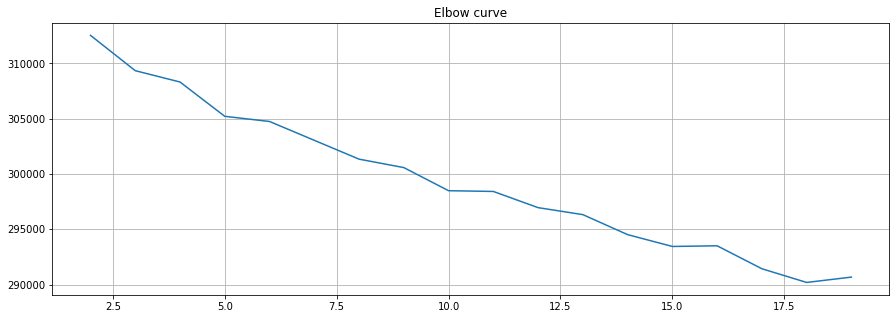

In [29]:
X = train_vector_new
distorsions = []
for k in tqdm(range(2, 20)):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)
plt.title('Elbow curve')

In [30]:
km = KMeans(
    n_clusters=12, init='random',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=42
)
y_km = km.fit_predict(train_vector_new)

In [31]:
km.labels_

array([ 0,  0,  0, ...,  0, 11,  0], dtype=int32)

In [32]:
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = feature_names
x = []
y = []
for i in range(12):
    print ("Cluster %d:" % i,)
    for ind in order_centroids[i, :20]:
        print (' %s' % terms[ind],)
        x.append(terms[ind])
    y.append(x)

Top terms per cluster:
Cluster 0:
 night recently
 one evening
 nervous not
 cramps terrible
 seroquel help
 mirena
 symptoms yi
 worth cost
 surgery week
 due diabetes
 implanon
 seroquel sleep
 free three
 lemon wedge
 daily eat
 medroxyprogesterone
 minimal cramps
 make itch
 feeling miserable
 things could
Cluster 1:
 fe
 quetiapine
 sprintec
 fluoxetine
 loestrin
 nuvaring
 lamotrigine
 buprenorphine
 desvenlafaxine
 tri
 lo
 pristiq
 20
 aripiprazole
 prozac
 24
 abilify
 microgestin
 naloxone
 people trouble
Cluster 2:
 levonorgestrel
 painful quick
 mg 25
 immensely
 glucose levels
 people trouble
 control effects
 sick nothing
 person took
 time long
 night recently
 see best
 contraceptive pill
 daily eat
 immediate
 benefits medication
 nervous not
 one evening
 injections week
 cramps terrible
Cluster 3:
 sertraline
 escitalopram
 lexapro
 clonazepam
 zoloft
 alprazolam
 paroxetine
 mirtazapine
 always given
 lasting long
 year lost
 oxygen levels
 days leave
 later eat
 ex

### Cluster Definitions

After considering all the important textual and numeric features we used the Kmeans clustering method to cluster the data into particular set of categories. we tried to calculate the silhoutte score and plotted the elbow curve which gave us 12 as optimal number of clusters. Below are the clusters defined:

### Cluster 0 : Weight Loss

Most common symptoms were related to <b> weight loss, obesity, irregular eating disorder </b> with most of medications/drugs such as <b> phentermine, lorcaserin, contrave </b> to treat weight loss and obesity symptoms. While <b> lisdexamfetamine </b> was used for <b> binge eating disorder </b>. In addition to this few outliers were seen related to treat diabetes with most taken drugs like liraglutide

### Cluster 1: Chronic Pain

This cluster classifies all <b> chronic pain and back pain</b> related illness with most common drugs such as:
1. oxycodone
2. acetaminophen
3. tramadol
4. hydrocodone
5. diclofenac
6. morphine
7. buprenorphine which were used to treat different type of pain illness.

### Cluster 2: Sleep Depressents

Most common symptoms observed were related to <b> sleep disorders/insomnia </b>. Drugs used to treat this order were mainly <b> zolpidem, suvorexant, quetiapine, temazepam, mirtazapine </b>. 

### Cluster 3: Stress and Anxiety

This clusters gives information for disorders such as anxiety, stress, depression, seizures and GAD disorders. Most common drugs monitored to treat such symptoms are escitalopram:
<b> alprazolam, citalopram, buspirone, clonazepam, lexapro, hydroxyzine, lorazepam

### Cluster 4: Fungal and Urinary Infections

Most common symptoms observed for people with <b>urinary tract infections</b> which can be due to <b> fungal, bacteria and unhiegenic sanitory conditions. <b> miconazole, tioconazole, nitrofurantoin, trimethoprim, sulfamethoxazole and ciprofloxacin </b> are top drugs monitored to treat these infections.

### Cluster 5: Skin and Acne 

Skin, acne type of infections are observed in this cluster with similar drugs treating the same illness such as <b>isotretinoin, adapalene, doxycycline, tretinoin

### Cluster 6: Arthritis and Bowel Illness

Most common symptoms found in this category are arthritis(knee pain), bowl syndrome, indigestion, and bleeding problems. Only two major drugs has been found to be important while clustering i.e. <b>opiate and osteoarthritis.

### Cluster 7: Contraception

Contraception pills, periods, abnormal bleeding, uterine infections are most common symptoms in this set of cluster with most commonly drug being used is <b>levonorgestrel</b> for birth control, and <b>bupropion, vareniclin</b> for smoking related illness

### Cluster 8: Depression

People with severe panic and anxiety, depression, and unwilling to socialize with others are the major affected group. <b>sertraline, quetiapine, lamotrigine and zoloft</b> are the major administered drugs for such treatment.

### Cluster 9: High Blood Pressure

People with <b>high blood pressure,strokes and cholestrol</b> were few symptoms observed wherein medication drugs like <b>lisinopril and amlodipine, losartan, and hydrochlorothiazide</b> are used to treat these symptoms.

### Cluster 10: Severe Anxiety Disorder

Cluster: 0


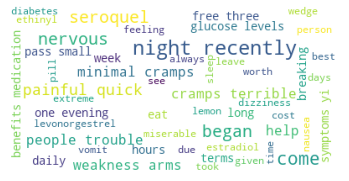

Cluster: 1


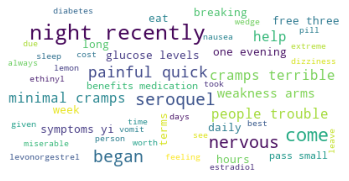

Cluster: 2


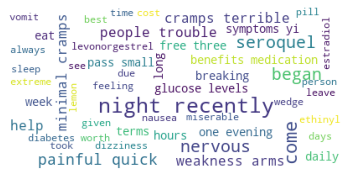

Cluster: 3


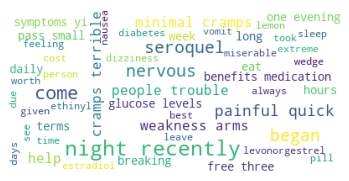

Cluster: 4


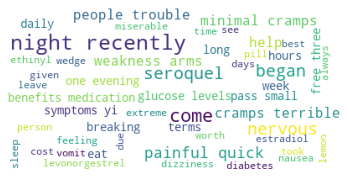

Cluster: 5


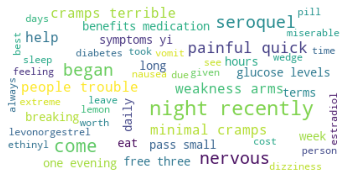

Cluster: 6


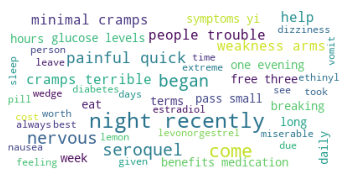

Cluster: 7


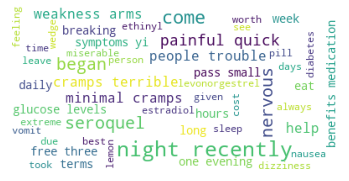

Cluster: 8


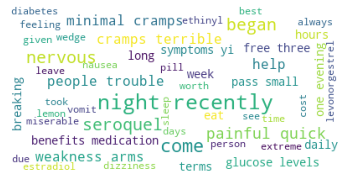

Cluster: 9


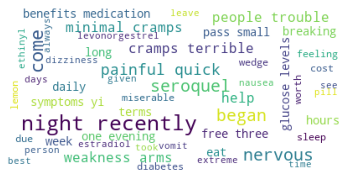

Cluster: 10


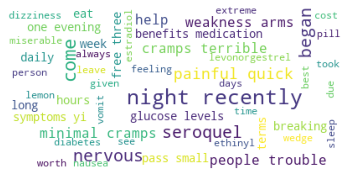

Cluster: 11


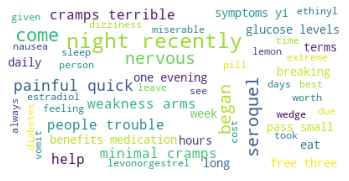

In [33]:
for i in range(12):

    wordcloud = WordCloud(max_font_size=25, max_words=50, background_color="white").generate(' '.join(y[i]))

    print('Cluster: {}'.format(i))
    # titles=wiki_cl[wiki_cl.cluster==k]['title']
    # print(titles.to_string(index=False))
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

In [34]:
result_df = df[['review']].copy()
result_df['review'] = result_df['review'] + df['drugName']
result_df['cluster'] = y_km

In [35]:
df['Cluster'] = km.labels_

In [36]:
df[df['Cluster'] == 0]['condition'].values

array(['Left Ventricular Dysfunction', 'ADHD', 'Birth Control', ...,
       'Nausea/Vomiting', 'Rheumatoid Arthritis', 'Constipation, Chronic'],
      dtype=object)

Cluster: 0


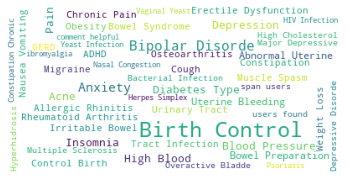

In [37]:
wordcloud = WordCloud(max_font_size=25, max_words=50, background_color="white").generate(' '.join(df[df['Cluster'] == 0]['condition'].values))

print('Cluster: 0')
# titles=wiki_cl[wiki_cl.cluster==k]['title']
# print(titles.to_string(index=False))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Cluster: 0


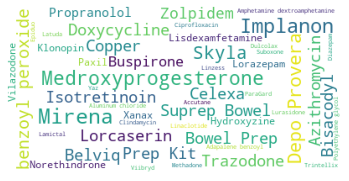

In [39]:
wordcloud = WordCloud(max_font_size=25, max_words=50, background_color="white").generate(' '.join(df[df['Cluster'] == 0]['drugName'].values))

print('Cluster: 0')
# titles=wiki_cl[wiki_cl.cluster==k]['title']
# print(titles.to_string(index=False))
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [40]:
df[df['Cluster'] == 0].condition.value_counts()

Birth Control                                  9504
Acne                                           4693
Pain                                           3752
Insomnia                                       3073
Anxiety                                        2952
                                               ... 
Small Bowel or Pancreatic Fistula                 1
77</span> users found this comment helpful.       1
Cyclitis                                          1
Ehrlichiosis                                      1
Pruritus of Partial Biliary Obstruction           1
Name: condition, Length: 851, dtype: int64

In [41]:
df[df['Cluster'] == 1].condition.value_counts()

Birth Control                                  3885
Depression                                     1789
Bipolar Disorde                                1051
Opiate Dependence                               499
Anxiety and Stress                              378
                                               ... 
Narcolepsy                                        1
43</span> users found this comment helpful.       1
21</span> users found this comment helpful.       1
18</span> users found this comment helpful.       1
8</span> users found this comment helpful.        1
Name: condition, Length: 69, dtype: int64

In [ ]:
df[df['Cluster'] == 2].condition.value_counts()

In [ ]:
df[df['Cluster'] == 3].condition.value_counts()

In [ ]:
df[df['Cluster'] == 4].condition.value_counts()

In [ ]:
df[df['Cluster'] == 5].condition.value_counts()

In [ ]:
df[df['Cluster'] == 6].condition.value_counts()

In [ ]:
df[df['Cluster'] == 7].condition.value_counts()

In [ ]:
df[df['Cluster'] == 8].condition.value_counts()

In [ ]:
df[df['Cluster'] == 9].condition.value_counts()

In [ ]:
df[df['Cluster'] == 10].condition.value_counts()

In [ ]:
df[df['Cluster'] == 11].condition.value_counts()